In [1]:
import platform
import subprocess

import cartopy.crs as ccrs
import dask
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import numpy as np
import pandas as pd
import scipy as sp
import torch
import torch_harmonics as th
import torch_harmonics.distributed as dist
import xarray

from subs1_utils import precompute_latitudes

# Model Variables
In the following cell you can set the values of the variables relevant to the model. The details of each variable are included in the README. In most cases it is only necessary to set values for the standard variables. Note that any variable included in the model should be given the same value in the postprocess. For example, if the model used zw = 42 and kmax = 11, you should use zw = 42 and kmax = 11 below.

In [2]:
# Set postprocess parameters.

# Standard Variables
zw = 63
expname = 'GammaT63L26_WarmPacOnly'
Topogdir = '/home/bkirtman/Work/Python/Scripts/AGCM/T63L26/InteractiveRainfall/'
dayst = 10800

# Advanced Variables
mw = None
imax = None
jmax = None
custom_path = None

In [ ]:
# Set Dependent Variables

# Check value for zw.
# Afterwards, set jmax and imax values based on the value given to zw.
# If a value is already given for one of the listed variables, use that instead
match zw:
    case 42:
        jmax = 64 if (jmax is None) else jmax
        imax = 128 if (imax is None) else imax
    case 63:
        jmax = 96 if (jmax is None) else jmax
        imax = 192 if (imax is None) else imax
    case 124:
        jmax = 188 if (jmax is None) else jmax
        imax = 376 if (imax is None) else imax
    case _:
        if (jmax is None) or (imax is None):
            raise Exception("Unexpected value for zw. Other values are implementable, but the user must specify values for jmax and imax in the advanced variables section.")

print("zw =", zw,
      "\njmax =", jmax,
      "\nimax =", imax,
      "\ndayst =", dayst)

In [ ]:
# Set datapath.

# If custom_path was set, use that as the datapath.
# Otherwise create an appropriate datapath for the user's operating system.
user_platform = platform.system() if (custom_path is None) else "Custom Path"
print("Setting output datapath for", user_platform)
datapath = ''
match user_platform:
    case 'Custom Path':
        datapath = custom_path
    case 'Windows':
        foo = str(subprocess.check_output(['whoami']))
        end = len(foo) - 5
        uname = foo[2:end].split("\\\\")[1]
        datapath = "C:\\Users\\" + uname + "\\Documents\\AGCM_Experiments\\" + expname + "\\"
    case 'Darwin':
        foo = str(subprocess.check_output(['whoami']))
        end = len(foo) - 3
        uname = foo[2:end]
        datapath = '/Users/' + uname + '/Documents/AGCM_Experiments/' + expname + '/'
    case _:
        raise Exception("Use case for this system/OS is not implemented. Consider using custom_path in the advanced variables.")

# Set stamp for file names
stamp = 'days_1-' + str(dayst)

print("datapath =", datapath,
      "\nstamp =", stamp)

In [3]:
#
fps = datapath+'lnps_1*.nc' 
dps = xarray.open_mfdataset(fps,decode_times=True,parallel = True)
#

In [4]:
dps

<xarray.Dataset>
Dimensions:  (time: 10800, lat: 96, lon: 192)
Coordinates:
  * time     (time) datetime64[ns] 1950-01-01 1950-01-02 ... 1979-07-27
  * lat      (lat) float64 88.57 86.72 84.86 83.0 ... -83.0 -84.86 -86.72 -88.57
  * lon      (lon) float64 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
Data variables:
    lnps     (time, lat, lon) float64 dask.array<chunksize=(30, 96, 192), meta=np.ndarray>

In [5]:
#
# Will need spectral transform topography to make sure we capture
# wiggles, so read in spectral topography from specific model simulation directory
# and convert to physical space
#
# Get the Gaussian latitudes and equally spaced longitudes
#
cost_lg, wlg, lats = precompute_latitudes(jmax)
lats = 90-180*lats/(np.pi)
lons = np.linspace(0.0,360.0-360.0/imax,imax)
Lon, Lat = np.meshgrid(lons, lats)
#
# Instantiate grid to spectral (dsht) and spectral to grid (disht) distibuted transforms
#
disht = dist.DistributedInverseRealSHT(jmax, imax, lmax=mw, mmax=zw, grid="legendre-gauss", csphase=False)
#
phismn = torch.load(Topogdir+'topog.spectral.pt')
phi = disht(phismn)
#

In [6]:
#
# Now calculate sea level pressure data use lnps, topography & temperature data
# This is a very simple formula - probably better techniques available
#
ftemp = datapath+'temp_1*.nc'
dtemp = xarray.open_mfdataset(ftemp,decode_times=True, parallel=True)
#
surfp = (np.exp(dps.lnps))*1000.0
laps = -0.0065
grav = 9.8
rgas = 287.04
tstar = dtemp.t[:,25,:,:]*(1+laps*(rgas/grav)*(1-dtemp['lev'][25]))
yy = -phi.numpy()*laps/(rgas*tstar)
slp = surfp * np.exp(phi.numpy()/(rgas*tstar)*(1-yy/2+(yy*yy)/3)) #ECMWF Formula for Sea Level Pressure
#
#

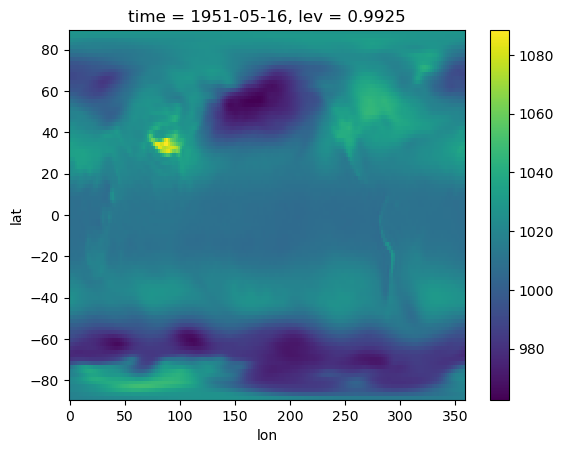

In [7]:
slp[500].plot()

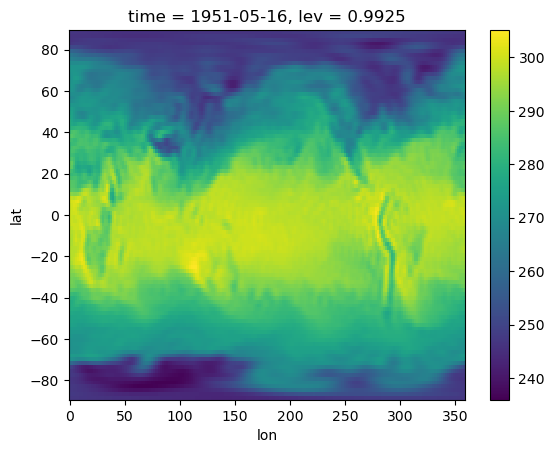

In [8]:
tstar[500].plot()

In [9]:
times = slp['time']
lats = slp['lat']
lons = slp['lon']
dData = xarray.Dataset({'slp': (['time','lat','lon'],slp.values)},
                        coords={'time': times, 'lat': lats, 'lon': lons})
dData.to_netcdf(datapath+'sealevelpressure_'+stamp+'.nc')